In [1]:
import os
### QAOA_realestate가 있는 폴더로 지정
dir_path = "/Users/minhyeong-gyu/Documents/GitHub/QAOA_realestate"
os.chdir(dir_path)
import sys
module_path = dir_path + "/Module"
if module_path not in sys.path:
    sys.path.append(module_path)

from optimizer import optimizer as opt
from optimizer import basefunctions as bf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import font_manager, rc
# 윈도우 한글 폰트
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# Mac 한글 폰트
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
from dwave.system import LeapHybridCQMSampler
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable 
from sklearn.preprocessing import MinMaxScaler

class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 

In [3]:
def transform_window(x,window):
    x = np.asarray(x)
    window_x = []
    for i in range(len(x)-window):
        window_x += [np.exp(sum([np.log(1+x[i+j]) for j in range(window)]))]
    return window_x

def MSE(y_true,y_pred):
    return np.linalg.norm(y_true-y_pred)**2

def MAE(y_true,y_pred):
    return np.linalg.norm(y_true-y_pred,1)

def R_square(y_true,y_pred):
    return 1-np.linalg.norm(y_true-y_pred)**2/np.linalg.norm(y_true-np.mean(y_true))**2

def windownsplit(X,window=5,ratio=0.8):
    X_window = np.array(transform_window(X,window))
    train_split = int(len(X_window)*ratio)
    X_train = np.array(X_window[:train_split,])
    X_test = np.array(X_window[train_split:,])
    return X_train,X_test

def k_lookback(y,look_back=5):
    n = len(y)
    y = np.asarray(y)
    y_lb = pd.DataFrame(y[look_back:])
    for i in range(1,look_back):
        y_lb[i] = np.asarray(y)[look_back-i:n-i]
    return y_lb.iloc[:,1:].values

In [148]:
X1 = pd.read_csv("data/Preprocessed_Data/X1.csv",index_col="Unnamed: 0")
y = pd.read_csv("data/Preprocessed_Data/Y.csv")

In [149]:
data = X1[['서울']].rename(columns={'서울':'X'}).copy()
data['y'] = y['신내동']

Xs = []
ys = []
lookback = 2
n = len(data)
n_train = int(n * 0.8)

for i in range(n-lookback): 
    X = data[i:i+2]
    y = data['y'][i+2]

    Xs.append(X)
    ys.append(y)

Xs = np.array(Xs)
ys = np.array(ys)

print(Xs.shape, ys.shape)


X_train, y_train = Xs[:n_train], ys[:n_train]
X_test, y_test = Xs[n_train:], ys[n_train:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(117, 2, 2) (117,)


((95, 2, 2), (95,), (22, 2, 2), (22,))

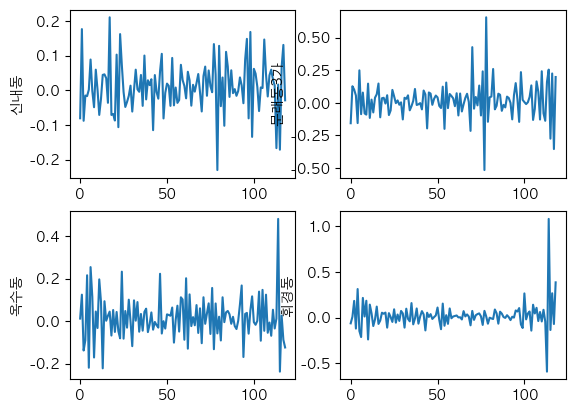

<Figure size 1500x1500 with 0 Axes>

In [47]:
fig, ax = plt.subplots(2,2)
plt.figure(figsize = (15,15))
sns.lineplot(ax = ax[0,0],x=range(119),y=y.iloc[:,1])
sns.lineplot(ax = ax[0,1],x=range(119),y=y.iloc[:,2])
sns.lineplot(ax = ax[1,0],x=range(119),y=y.iloc[:,3])
sns.lineplot(ax = ax[1,1],x=range(119),y=y.iloc[:,4])
plt.show()

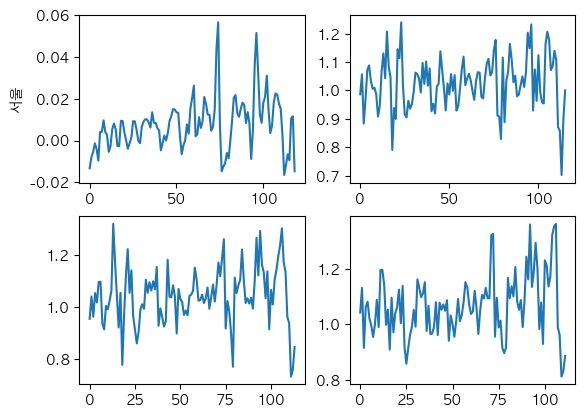

<Figure size 1500x1500 with 0 Axes>

In [48]:
fig, ax = plt.subplots(2,2)
plt.figure(figsize = (15,15))
sns.lineplot(ax = ax[0,0],x=range(len(y)), y=X1.iloc[:,1])
window=3
sns.lineplot(ax = ax[0,1],x=range(len(y)-window), y=transform_window(y.iloc[:,1],window))
window=5
sns.lineplot(ax = ax[1,0],x=range(len(y)-window), y=transform_window(y.iloc[:,1],window))
window=7
sns.lineplot(ax = ax[1,1],x=range(len(y)-window), y=transform_window(y.iloc[:,1],window))
plt.show()

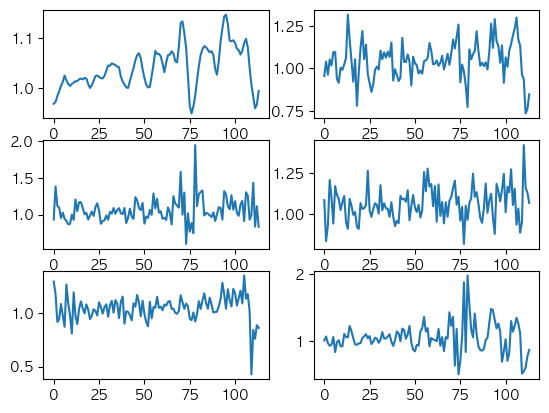

<Figure size 1500x1500 with 0 Axes>

In [49]:
window = 5
fig, ax = plt.subplots(3,2)
plt.figure(figsize = (15,15))
sns.lineplot(ax = ax[0,0],x=range(len(y)-window), y=transform_window(X1.iloc[:,1],window))
sns.lineplot(ax = ax[0,1],x=range(len(y)-window), y=transform_window(y.iloc[:,1],window))
sns.lineplot(ax = ax[1,0],x=range(len(y)-window), y=transform_window(y.iloc[:,2],window))
sns.lineplot(ax = ax[1,1],x=range(len(y)-window), y=transform_window(y.iloc[:,3],window))
sns.lineplot(ax = ax[2,0],x=range(len(y)-window), y=transform_window(y.iloc[:,4],window))
sns.lineplot(ax = ax[2,1],x=range(len(y)-window), y=transform_window(y.iloc[:,5],window))
plt.show()

In [50]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(X1.iloc[:,1:2].values,y.iloc[:,1])
lr.score(X1.iloc[:,1:2].values,y.iloc[:,1])

0.03442195426931771

In [51]:
y

,계약날짜,신내동,문래동3가,옥수동,휘경동,답십리동,신길동,고척동,방학동,가양동,...,하계동,서초동,시흥동,신도림동,불광동,금호동1가,수색동,홍은동,우면동,종암동
0,201207,-0.080720,-0.156774,0.011721,-0.063545,0.082297,0.394790,-0.043526,0.051611,0.032827,...,0.013177,0.652592,0.003870,-0.250777,0.033961,0.063326,-0.046875,0.094138,0.253235,-0.090766
1,201208,0.176547,0.126996,0.124024,0.008929,0.005154,-0.122238,-0.343329,-0.026184,-0.078333,...,0.195568,-0.231124,0.061742,0.207464,0.112809,0.091902,0.016393,0.030504,0.199412,-0.051960
2,201209,-0.087963,0.101102,-0.138423,0.182965,-0.003032,0.195424,0.400487,0.121840,0.061980,...,0.058816,-0.000089,0.013383,-0.009527,-0.114976,-0.069518,0.012903,0.197942,0.000000,0.012456
3,201210,-0.015050,0.055868,-0.089162,-0.120884,-0.024204,-0.137913,0.181865,-0.120002,0.175581,...,-0.079212,0.135942,-0.059675,-0.108275,0.006463,0.062332,-0.022824,-0.071803,-0.386923,0.005249
4,201211,-0.016784,-0.155543,0.215233,0.313110,-0.048761,0.019793,-0.034712,0.089072,-0.132248,...,0.056200,-0.149454,0.006242,-0.030765,0.078421,-0.037173,-0.008419,0.031852,0.273526,0.025198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,202201,0.016535,0.254237,0.480163,1.082958,0.245610,-0.161177,-0.250000,0.039384,-0.209944,...,-0.163921,-0.486263,-0.036012,0.057177,0.548091,0.415638,0.284314,-0.070175,-0.059783,0.235207
115,202202,-0.171343,-0.275104,-0.237801,-0.136364,0.015511,-0.136160,0.064599,-0.577592,-0.223069,...,-0.155172,1.204297,-0.105324,-0.497630,-0.240108,0.002253,-0.308353,0.009771,-0.498555,0.127480
116,202203,0.067532,0.224779,0.025586,0.266667,0.369686,0.211370,-0.050728,1.091260,0.520686,...,0.315379,-0.518559,-0.004740,0.491260,-0.015087,-0.361902,0.639758,-0.166786,0.829971,-0.286000
117,202204,0.130927,-0.354642,-0.088091,-0.070959,0.013246,0.422610,0.000511,-0.027047,-0.216176,...,-0.046323,1.270131,0.151027,0.073123,0.234574,0.256818,-0.276923,0.237859,-0.135433,0.060691


In [52]:
from sklearn import linear_model
model = linear_model.LinearRegression()
score_df = pd.DataFrame()
for j in range(1,11,2):
    window = j
    total_length = len(y)-window
    train_index = int(0.8*(total_length)) 
    test_index = total_length - train_index
    X_1 = pd.DataFrame(transform_window(X1.iloc[:,1],window))
    score = [] 
    for i in range(len(y)-6):
        model.fit(X_1.iloc[:train_index,:],transform_window(y.iloc[:,i+1],window)[:train_index])
        score += [lr.score(X_1.iloc[train_index:total_length,:],transform_window(y.iloc[:,i+1],window)[train_index:total_length])]
    score_df[str(j)] = score

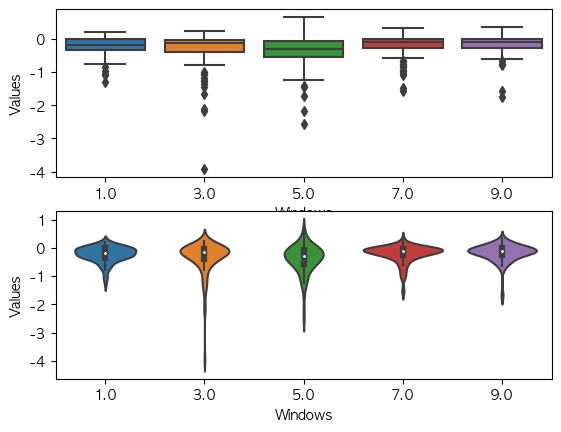

In [53]:
plot_data =pd.DataFrame([score_df.values.flatten(),np.array([[j for i in range(113)] for j in range(1,11,2)]).reshape(-1)]).T
plot_data.columns = ["Values","Windows"]
fig,axes = plt.subplots(2,1)
sns.boxplot(ax=axes[0],data=plot_data, x = "Windows", y = "Values")
sns.violinplot(ax=axes[1],data=plot_data, x = "Windows", y = "Values")
plt.show()

In [54]:
from sklearn import svm
svr = svm.SVR()
svr.fit(X1.iloc[:,1:2].values,y.iloc[:,1])
svr.score(X1.iloc[:,1:2].values,y.iloc[:,1])

0.02273704157503642

In [55]:
from sklearn import svm
model = svm.SVR()
score_df = pd.DataFrame()
for j in range(1,11,2):
    window = j
    total_length = len(y)-window
    train_index = int(0.8*(total_length)) 
    test_index = total_length - train_index
    X_1 = pd.DataFrame(transform_window(X1.iloc[:,1],window))
    score = [] 
    for i in range(len(y)-6):
        model.fit(X_1.iloc[:train_index,:],transform_window(y.iloc[:,i+1],window)[:train_index])
        score += [model.score(X_1.iloc[train_index:total_length,:],transform_window(y.iloc[:,i+1],window)[train_index:total_length])]
    score_df[str(j)] = score

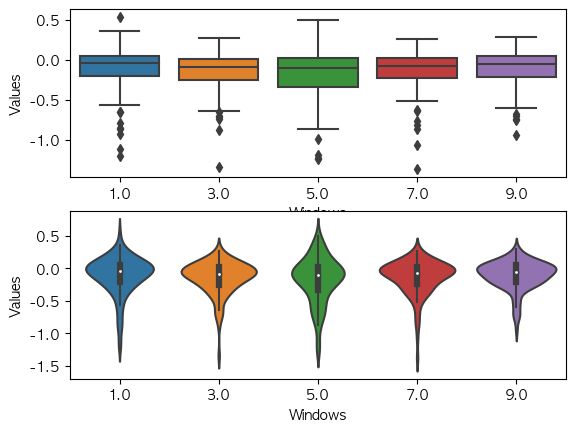

In [56]:
plot_data =pd.DataFrame([score_df.values.flatten(),np.array([[j for i in range(113)] for j in range(1,11,2)]).reshape(-1)]).T
plot_data.columns = ["Values","Windows"]
fig,axes = plt.subplots(2,1)
sns.boxplot(ax=axes[0],data=plot_data, x = "Windows", y = "Values")
sns.violinplot(ax=axes[1],data=plot_data, x = "Windows", y = "Values")
plt.show()

In [57]:
from sklearn import ensemble
model = ensemble.AdaBoostRegressor()
score_df = pd.DataFrame()
for j in range(1,11,2):
    window = j
    total_length = len(y)-window
    train_index = int(0.8*(total_length)) 
    test_index = total_length - train_index
    X_1 = pd.DataFrame(transform_window(X1.iloc[:,1],window))
    score = [] 
    for i in range(len(y)-6):
        model.fit(X_1.iloc[:train_index,:],transform_window(y.iloc[:,i+1],window)[:train_index])
        score += [model.score(X_1.iloc[train_index:total_length,:],transform_window(y.iloc[:,i+1],window)[train_index:total_length])]
    score_df[str(j)] = score

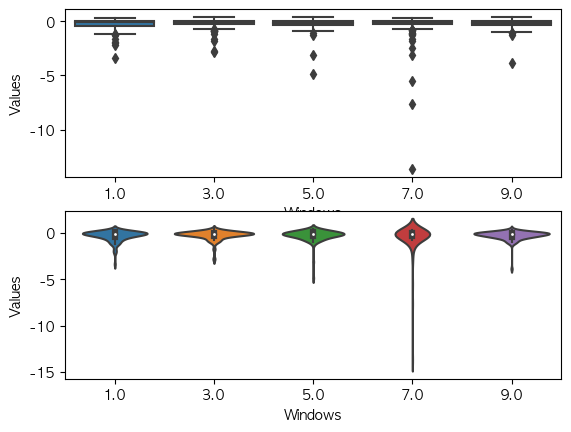

In [58]:
plot_data =pd.DataFrame([score_df.values.flatten(),np.array([[j for i in range(113)] for j in range(1,11,2)]).reshape(-1)]).T
plot_data.columns = ["Values","Windows"]
fig,axes = plt.subplots(2,1)
sns.boxplot(ax=axes[0],data=plot_data, x = "Windows", y = "Values")
sns.violinplot(ax=axes[1],data=plot_data, x = "Windows", y = "Values")
plt.show()